# DSCI-100 Project

In [1]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(GGally)
library(tidymodels)
set.seed(1000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.0.1
✔ recipes      1.1.0     ✔ 

## Introduction
This project will be analyzing data obtained from [a research group in Computer Science at UBC](https://plai.cs.ubc.ca/), led by [Frank Wood](https://www.cs.ubc.ca/~fwood/). Specifically, these data are obtained from numerous players' actions in the video game Minecraft. In interest of collecting data efficiently, this analysis will focus on which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

### File players.csv:
- `experience` Refers to the player's experience with Minecraft as the following:
    * Pro
    * Veteran
    * Regular
    * Amateur
    * Beginner
- `subscribe` Refers to whether the player has subscribed to game-related newsletters.
- `hashedEmail` Player email, obfuscated for privacy.
- `played_hours` Player's total hours spent playing.
- `name` Player's name.
- `gender` Player's gender.
- `age` Player's age.

### File sessions.csv:
- `hashedEmail` Player email, obfuscated for privacy.
- `start_time` Session start time in human readable time.
- `end_time` Session end time in human readable time.
- `original_start_time` Session start time in Epoch time.
- `original_end_time` Session end time in Epoch time.

### The Big Question
Can we predict a player's average session time based on their total hours? <br>

## Loading and Cleaning the Data

In [7]:
players_data <- read_csv("https://raw.githubusercontent.com/Freddy891/dsci-100-project/main/players.csv")
clean_players <- players_data |>
    rename(age = Age, email = hashedEmail) |>
    select(email, played_hours, name)

session_data <- read_csv("https://raw.githubusercontent.com/Freddy891/dsci-100-project/main/sessions.csv")
clean_session <- session_data |>
    rename(email = hashedEmail) |>
    select(email:end_time) |>
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time)) |>
    mutate(session_duration = end_time-start_time) |>
    select(session_duration, email)

analysis_data <- merge(clean_players, clean_session, by="email") |>
    group_by(email) |>
    summarize(avg_session = mean(session_duration)) |>
    mutate(avg_session = gsub("mins", "", avg_session)) |>
    mutate(avg_session = as.numeric(avg_session)) |>
    mutate(avg_session_hrs = round(avg_session/60, 2)) |>
    select(-avg_session) |>
    merge(clean_players, by="email")

head(analysis_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,email,avg_session_hrs,played_hours,name
,<chr>,<dbl>,<dbl>,<chr>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,0.88,1.5,Isaac
2,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,0.50,0.4,Lyra
3,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,0.18,0.1,Osiris
4,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,0.54,5.6,Winslow
5,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,0.58,1.0,Knox
6,11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,0.17,0.1,Callum


## Visualization
Now we have the data ready for analysis and splitting. Every participant have their average session playtime recorded in hours and total hours recorded in two columns.<br>
We will now plot the relationship of these two variables.

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


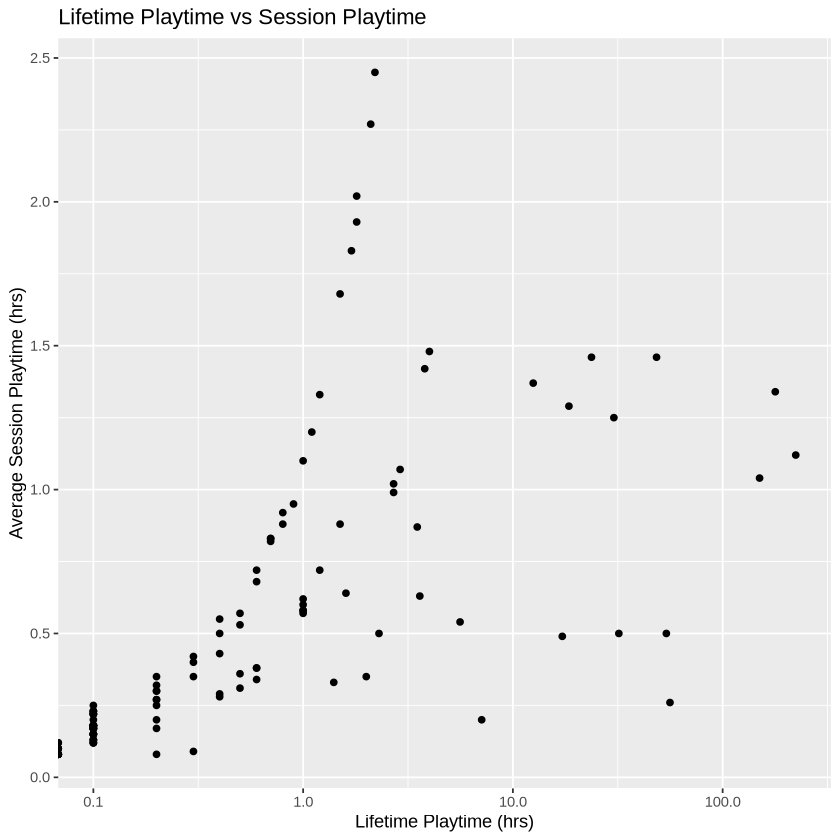

In [3]:
session_plot <- analysis_data |>
    ggplot(aes(played_hours, avg_session_hrs)) +
    geom_point() +
    labs(x="Lifetime Playtime (hrs)", y="Average Session Playtime (hrs)") +
    ggtitle("Lifetime Playtime vs Session Playtime") +
    scale_x_log10()

session_plot

From the plot we can see that there is a positive relationship between total playtime and session averages. Since this trend isn't linear, we will be using KNN regression. Despite the limitations of KNN regression, the above trend suggest that a linear regression will lead to very high average session playtimes as lifetime playtime increase, therefore this analysis will stick to the data range given.

## KNN Regression
Now we will split the data into training and testing, use 5 vold cross validation and create a model for this relationship.

[1] 18

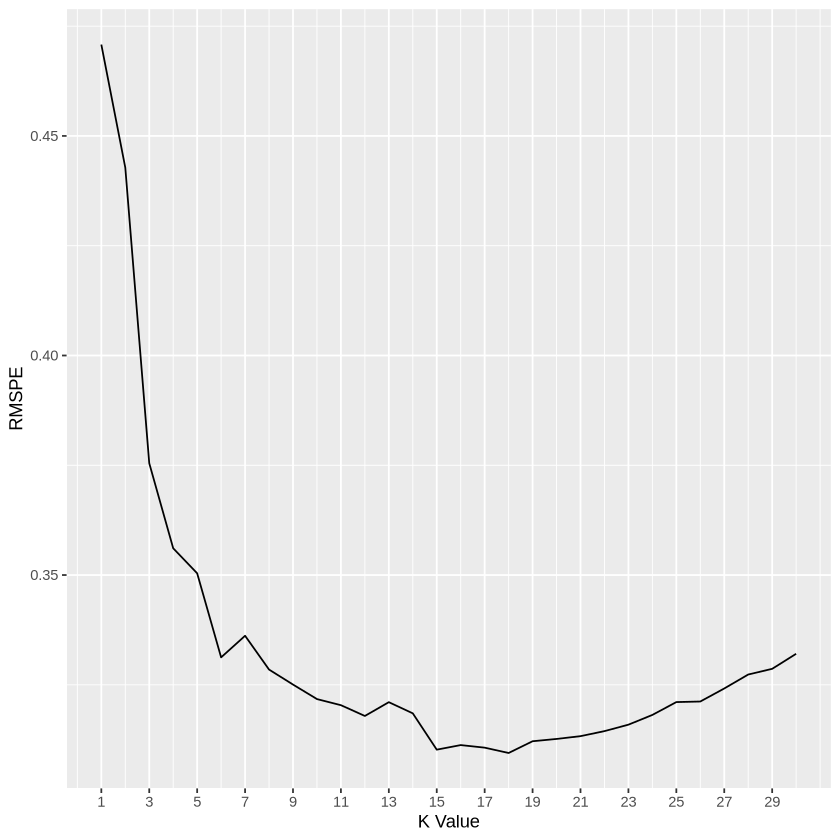

In [4]:
analysis_split <- initial_split(analysis_data, prop = .75, strata = avg_session_hrs)
analysis_testing <- testing(analysis_split)
analysis_training <- training(analysis_split)

analysis_recipe <- recipe(avg_session_hrs~played_hours, data=analysis_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

analysis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

analysis_vfold <- vfold_cv(analysis_training, strata = avg_session_hrs)

k_vals <- tibble(neighbors = 1:30)

analysis_results <- workflow() |>
    add_recipe(analysis_recipe) |>
    add_model(analysis_spec) |>
    tune_grid(resamples = analysis_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

analysis_plot <- analysis_results |>
    ggplot(aes(neighbors, mean)) +
    geom_line() +
    labs(x="K Value", y="RMSPE") +
    scale_x_continuous(breaks = seq(1, 30, by = 2))

analysis_plot
best_k <- analysis_results |>
    arrange(mean) |>
    slice(1) |>
    pull(neighbors)
best_k

To minimize RMSPE, we will select the best k value to use in our final model, which will be tested using the testing split.

In [5]:
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("regression")

final_results <- workflow() |>
    add_recipe(analysis_recipe) |>
    add_model(final_spec) |>
    fit(analysis_testing) |>
    predict(analysis_testing) |>
    bind_cols(analysis_testing) 

metrics <- final_results |>
    metrics(truth = avg_session_hrs, estimate = .pred) |>
    filter(.metric == 'rmse')

metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.3878798


This gives the model's test error, of around 0.38 hours error. <br>
The error is quite large given that the average playtime rarely exceeds an hour.

## Final Visualization

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


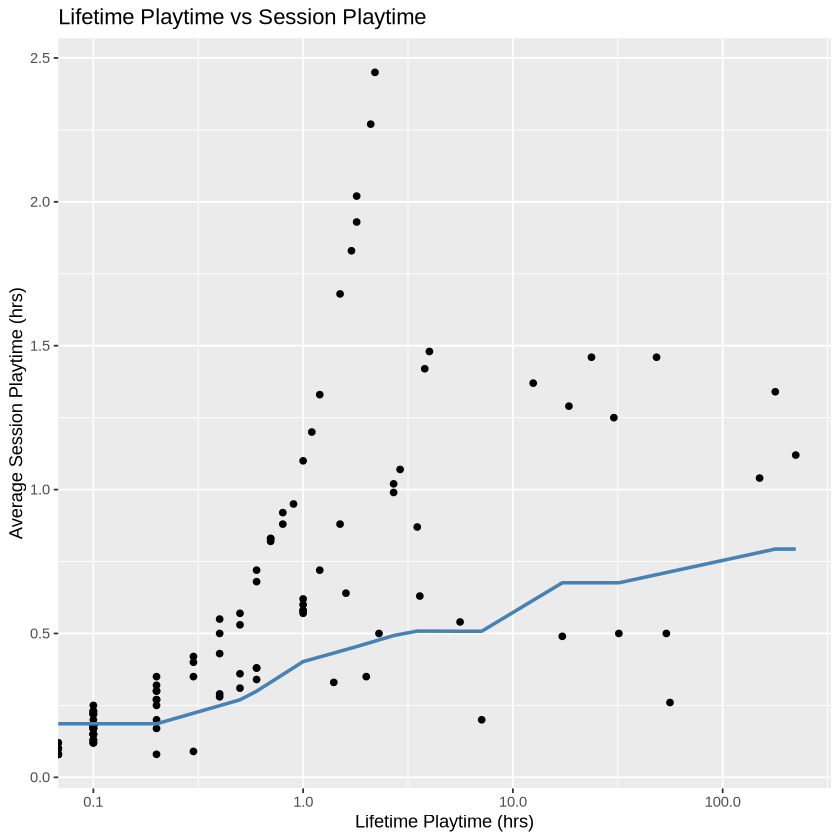

In [13]:
final_plot <- analysis_data |>
    ggplot(aes(played_hours, avg_session_hrs)) +
    geom_point() +
    geom_line(data = final_results,
        mapping = aes(x = played_hours, y = .pred),
        color = "steelblue",
        linewidth = 1) +
    labs(x="Lifetime Playtime (hrs)", y="Average Session Playtime (hrs)") +
    ggtitle("Lifetime Playtime vs Session Playtime") +
    scale_x_log10()

final_plot

## Conclusion

Although the model error is on the higher end, I think it can still be used as a reference to predict playtime based on a player's lifetime playtime. <br>
To answer our original question, yes, I think the model shows that there is a positive relationship between lifetime playtime and the player's average session. <br>
This can be helpful because we can have a reference on a potential player's contribution of data for the research group. The higher the average playtime the player will have, the more data they will obtain for the research.